# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

<b>Выгрузим необходимые библиотеки:</b>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

<b>Открываем файл:</b>

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t')

<b>Рассмотрим датафрейм:</b>

In [3]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<b>Изучим общую информацию:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
null_shape = df.shape
null_shape

(23699, 22)

<b>Построим гистограммы полей с численными значениями:

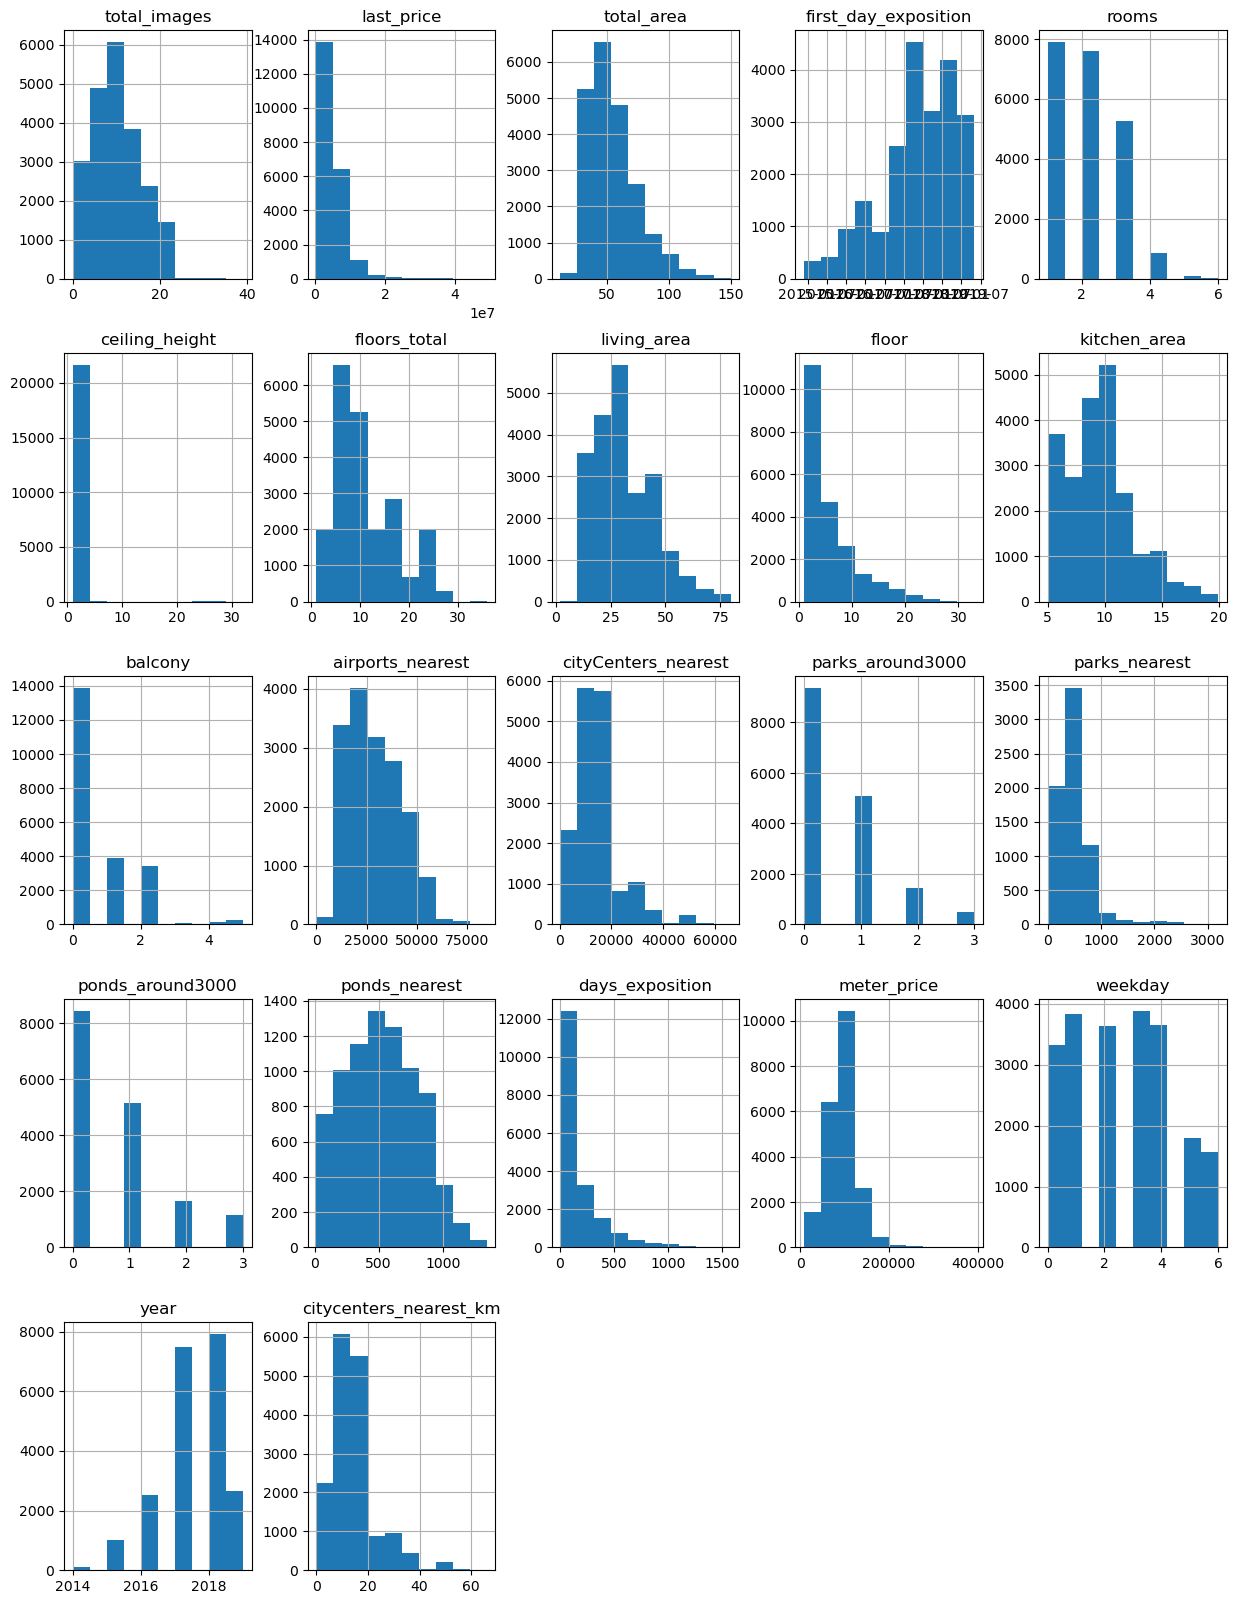

In [88]:
df.hist(figsize=(15, 20))
plt.title('Your Title Here')
plt.show()

### Предобработка данных

<b>Создадим таблицу с наименованием столбцов с пропущенными значениями и их количеством:

In [7]:
null_rows = df.isna().sum() 
null_rows = null_rows[null_rows != 0]
print(null_rows)

ceiling_height          9195
floors_total              86
living_area             1903
is_apartment           20924
kitchen_area            2278
balcony                11519
locality_name             49
airports_nearest        5542
cityCenters_nearest     5519
parks_around3000        5518
parks_nearest          15620
ponds_around3000        5518
ponds_nearest          14589
days_exposition         3181
dtype: int64


<b>Для наглядности, можно построить хитмап:

<function matplotlib.pyplot.show(close=None, block=None)>

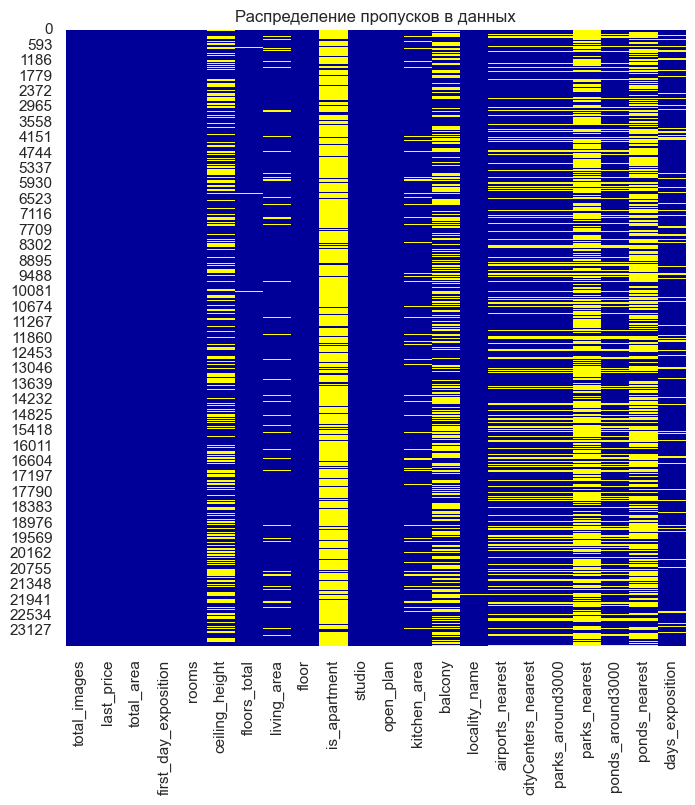

In [8]:
sns.set(rc={'figure.figsize':(8, 8)})
colours = ['#000099', '#ffff00'] 
(sns.heatmap(df.isnull(), cmap=sns.color_palette(colours), cbar=False)
    .set(title='Распределение пропусков в данных'))
plt.show

<b>Для удобства, сразу переведем дату в доступный формат (это потребуется позднее):

In [9]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%d')
print(df['first_day_exposition'].sort_values().head())

10132   2014-11-27
8393    2014-11-27
15857   2014-11-27
2831    2014-11-27
696     2014-11-27
Name: first_day_exposition, dtype: datetime64[ns]


<b>В столбце ceiling_height указана высота потолков в квартире, заменим средним значением:

In [10]:
ceiling_mean = df['ceiling_height'].mean()
df['ceiling_height'] = df['ceiling_height'].fillna(ceiling_mean)

<b>В столбце floors_total указано общее количество этажей в доме. Логичную замену предложить невозможно, а количество пропусков невелико, поэтому удалим строки с пропусками:

In [11]:
df.dropna(subset=['floors_total'], inplace=True)

<b>В столбце living_area указана жилая площадь в квартире. Логично, что параметр зависит от количества комнат:

In [12]:
df['living_area'].corr(df['rooms']).round(3)

0.846

<b>Корреляция высока, поэтому заменим пропуски, исходя из количества комнат:

In [13]:
for t in df['rooms'].unique():
    df.loc[(df['rooms'] == t) & (df['living_area'].isna()), 'living_area'] = \
    df.loc[(df['rooms'] == t), 'living_area'].median()

<b>В столбце is_apartment указано, является ли помещение апартаментами. Попробуем выявить закономерность, возможно, объявления начали публиковаться не сразу:

In [14]:
print(df['is_apartment'].value_counts())
print(df.loc[df['is_apartment'] == True, 
             ['first_day_exposition', 'is_apartment']]
        .sort_values(by='first_day_exposition')
        .head())

False    2725
True       50
Name: is_apartment, dtype: int64
      first_day_exposition is_apartment
1109            2014-12-09         True
11492           2014-12-09         True
10867           2015-01-15         True
8018            2015-12-17         True
7521            2015-12-17         True


<b>Возможно, влияет кухня:

In [15]:
df.query('is_apartment == True')['kitchen_area'].head()

543      NaN
916      NaN
1109    20.0
1608     NaN
2759     NaN
Name: kitchen_area, dtype: float64

<b>Явных закономерностей не обнаружено. Заменим пропущенные значения на False, но лучше узнать у сервиса, сколько на самом деле выкладывается объявлений с апартаментами:

In [16]:
df['is_apartment'] = df['is_apartment'].fillna(False)

<b>В столбце kitchen_area указана площадь кухни. Проверим, зависит ли площадь кухни от количества комнат:

In [17]:
df['kitchen_area'].corr(df['rooms']).round(3)

0.27

<b>Зависимости нет. По СНиП, площадь кухни не может быть меньше 5 м2, поэтому заменяем значения на среднее в пропущенных ячейках и строках с маленькими кухнями:

In [18]:
df.loc[df['kitchen_area'] < 5,'kitchen_area'] = np.nan

In [19]:
kitchen_mean = df['kitchen_area'].mean()
df['kitchen_area'] = df['kitchen_area'].fillna(kitchen_mean)

<b>В столбце balcony указано количество балконов. Логично, что неуказанные значения логично заменить нулём.

In [20]:
df['balcony'] = df['balcony'].fillna(0)

<b>В столбце locality_name указаны населенные пункты. Логичную замену предложить невозможно, а количество пропусков невелико, поэтому удалим строки с пропусками:

In [21]:
df.dropna(subset=['locality_name'], inplace=True)

<b>В столбце airports_nearest указано расстояние до ближайшего аэропорта. В населенных пунктах (кроме Санкт-Петербурга), поэтому сначала избавимся от дубликатов:

In [22]:
import re
from collections import Counter

def locality_duplicates(df):
    locality_list = ' '.join(df['locality_name'].unique())
    locality_list = re.split(' ', locality_list)

    locality_list = {k:v for k, v in Counter(locality_list).items() if v > 1}

    lower_loc_keys= []

    for key in locality_list.keys():
        if key[0].islower():
            lower_loc_keys.append(key)
        
    upper_loc_keys= []

    for key in locality_list.keys():
        if key[0].isupper():
            upper_loc_keys.append(key)
    
    return(lower_loc_keys, upper_loc_keys)
print(locality_duplicates(df))

locality_list = ' '.join(df['locality_name'].unique())
locality_list = re.split(' ', locality_list)

locality_list = {k:v for k, v in Counter(locality_list).items() if v > 1}
print(locality_list)

(['посёлок', 'городской', 'деревня', 'поселок', 'городского', 'типа', 'садовое', 'товарищество', 'село', 'имени', 'станции', 'при', 'железнодорожной', 'коттеджный'], ['Янино-1', 'Мурино', 'Кудрово', 'Красный', 'Бор', 'Фёдоровское', 'Лебяжье', 'Кузьмоловский', 'Новая', 'Ропша', 'Аннино', 'Старая', 'Новый', 'Свет', 'Никольское', 'Романовка', 'Бугры', 'Рощино', 'Павлово', 'Победа', 'Терволово', 'Советский', 'Петровское', 'Токсово', 'Вырица', 'Тельмана', 'Большая', 'Ижора', 'Лесогорский', 'Рахья', 'Колпаны', 'Ладога', 'Зимитицы', 'Свердлова', 'Рябово', 'Бегуницы', 'Поляны', 'Мга', 'Малое', 'Мичуринское', 'Ильичёво', 'Вещево', 'Калитино', 'Приладожский', 'Щеглово', 'Гаврилово', 'Рабитицы', 'Назия', 'Малукса', 'Гарболово', 'Приветнинское', 'Мельниково', 'Усть-Луга', 'Любань', 'Стеклянный', 'Форносово', 'Сумино', 'Возрождение', 'Красная', 'Горка', 'Лисий', 'Нос', 'Жилгородок', 'Громово', 'Коробицыно', 'Кобралово', 'Лесное', 'Перово', 'Пансионат', 'Зелёный'])
{'посёлок': 94, 'городской': 14, '

<b>В обозначении населенных пунктов необходимо изменить "поселок", "поселок городского типа" и "поселок при железнодорожной станции":</b>

In [23]:
df['locality_name'] = df['locality_name'].str.replace('поселок','посёлок')
df['locality_name'] = df['locality_name'].str.replace('городской посёлок','посёлок городского типа')
df['locality_name'] = df['locality_name'].str.replace('посёлок при железнодорожной станции', 'посёлок станции')

<b>Теперь, заменим повторяющиеся названия населенных пунктов, записанных по-разному:</b>

In [24]:
upper_duplicates, lower_duplicates = locality_duplicates(df)
upper = []
for i in df['locality_name'].unique():
    for k in lower_duplicates:
        if k in i:
            upper.append(i)
print(upper)
#здесь нужно изменять вручную, например, есть и деревня Щеглово, и посёлок, 
#Красных Боров в Ленинградской области вообще 5! 

['посёлок Мурино', 'деревня Кудрово', 'посёлок городского типа Красный Бор', 'деревня Фёдоровское', 'садовое товарищество Новая Ропша', 'садовое товарищество Новая Ропша', 'деревня Старая', 'посёлок Новый Свет', 'Мурино', 'Никольское', 'Сосновый Бор', 'Кудрово', 'посёлок Романовка', 'село Павлово', 'посёлок городского типа Большая Ижора', 'посёлок городского типа Павлово', 'посёлок городского типа Рахья', 'деревня Большие Колпаны', 'посёлок городского типа Фёдоровское', 'Новая Ладога', 'Новая Ладога', 'посёлок Зимитицы', 'посёлок Рябово', 'деревня Бегуницы', 'деревня Малое Карлино', 'деревня Малое Верево', 'деревня Калитино', 'деревня Чудской Бор', 'посёлок Ропша', 'посёлок городского типа Приладожский', 'посёлок Щеглово', 'деревня Рабитицы', 'деревня Малые Колпаны', 'посёлок Старая Малукса', 'садовое товарищество Рахья', 'деревня Старые Бегуницы', 'деревня Гарболово', 'Любань', 'посёлок городского типа Рябово', 'село Никольское', 'село Старая Ладога', 'село Старая Ладога', 'посёлок Кр

In [25]:
df['locality_name'] = df['locality_name'].str.replace('посёлок Мурино','Мурино')
df['locality_name'] = df['locality_name'].str.replace('деревня Кудрово','Кудрово')
df['locality_name'] = df['locality_name'].str.replace('городской посёлок Фёдоровское', 'деревня Фёдоровское')
df['locality_name'] = df['locality_name'].str.replace('село Никольское', 'Никольское')

<b>В Cанкт-Петербурге и Ленинградской области один аэропорт - Пулково, поэтому, расстояние до него в населенных пунктах (кроме СПб, город слишком большой) примерно равное.</b>

In [26]:
null_airports = df.query('~airports_nearest.isnull()')['locality_name'].value_counts() 

result_airports = pd.concat([null_airports, df['locality_name'].value_counts()], axis=1)

result_airports.columns = ['notnull_air_locality', 'all_locality']
result_airports['delta'] = result_airports['all_locality'] - result_airports['notnull_air_locality']

result_airports.sort_values(by='all_locality', ascending=False).head(10)

,notnull_air_locality,all_locality,delta
Санкт-Петербург,15567.0,15651,84.0
Мурино,NaN,586,NaN
Кудрово,NaN,470,NaN
посёлок Шушары,436.0,439,3.0
Всеволожск,NaN,398,NaN
Пушкин,369.0,369,0.0
Колпино,337.0,338,1.0
посёлок Парголово,327.0,327,0.0
Гатчина,NaN,307,NaN
Выборг,NaN,237,NaN


In [27]:
result_airports = (result_airports.dropna()
                                  .query('delta != 0')
                                  .drop(index='Санкт-Петербург'))
result_airports.sort_values(by='delta', ascending=False)

,notnull_air_locality,all_locality,delta
посёлок Шушары,436.0,439,3.0
Красное Село,174.0,176,2.0
Колпино,337.0,338,1.0
Ломоносов,132.0,133,1.0
Кронштадт,95.0,96,1.0


In [28]:
for t in result_airports.index:
        df.loc[(df['locality_name'] == t) & (df['airports_nearest'].isna()), 'airports_nearest'] = \
        df.loc[(df['locality_name'] == t), 'airports_nearest'].median()

<b>Таким образом, мы заполнили немного пустых ячеек. Мелочь, а приятно.

<b>Аналогично с расстоянием до аэропорта, в cityCenters_nearests заменяем пустые значения:

In [29]:
null_centers = df.query('~cityCenters_nearest.isnull()')['locality_name'].value_counts() 

result_centers = pd.concat([null_centers, df['locality_name'].value_counts()], axis=1)

result_centers.columns = ['notnull_center_locality', 'all_locality']
result_centers['delta'] = result_centers['all_locality'] - result_centers['notnull_center_locality']

result_centers = (result_centers.dropna()
                                .query('delta != 0')
                                .drop(index='Санкт-Петербург'))

result_centers.sort_values(by='delta', ascending=False)

,notnull_center_locality,all_locality,delta
посёлок Шушары,436.0,439,3.0
Красное Село,174.0,176,2.0
Пушкин,368.0,369,1.0
Колпино,337.0,338,1.0
Ломоносов,132.0,133,1.0
Кронштадт,95.0,96,1.0


In [30]:
for t in result_centers.index:
        df.loc[(df['locality_name'] == t) & (df['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
        df.loc[(df['locality_name'] == t), 'cityCenters_nearest'].median()

 <b>Для заполнения пропусков в столбцах parks_around3000, parks_nearest, ponds_around3000, ponds_nearest слишком мало данных о местоположении.</b>

<b>В столбце days_exposition пропуски заполнять не будем. Скорее всего, это означает, что объявление актуально. Проверим:</b>

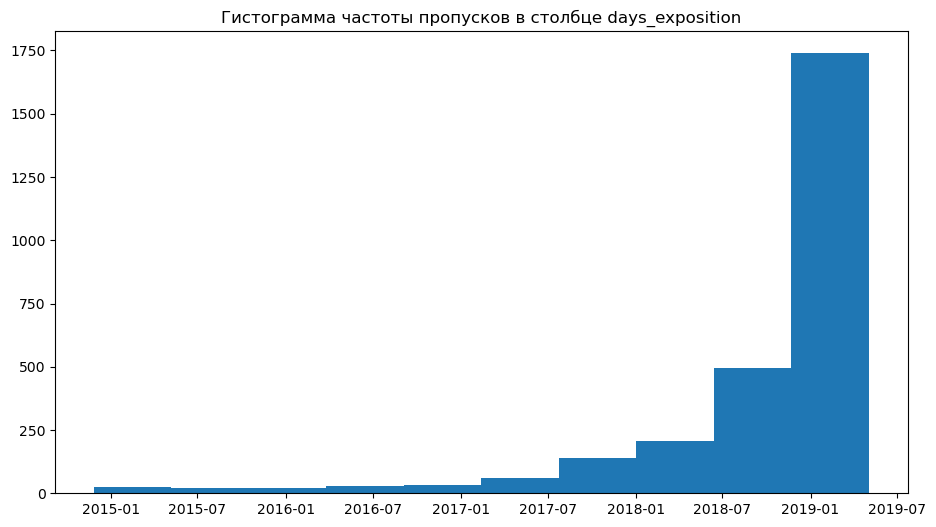

In [109]:
plt.style.use('default')
plt.figure(figsize=(11, 6))
plt.hist(df[df.days_exposition.isna()]['first_day_exposition'])
plt.title('Гистограмма частоты пропусков в столбце days_exposition')
plt.show()

<b>Проверим на явные дубликаты:</b>

In [32]:
df.duplicated().sum()

0

<b>Изменим тип данных, где это возможно:</b>

In [33]:
df = df.astype({
                'balcony':'int',
                'floors_total':'int',
                'last_price':'int',
                'living_area':'float32' #изменяем для экономии памяти
                     })

### Добавим в таблицу новые столбцы

<b>Добавляем столбец с ценой за один квадратный метр:

In [34]:
df['meter_price'] = df['last_price'] / df['total_area']

<b>Добавляем столбец с днем недели публикации объявления:

In [35]:
df['weekday'] = df['first_day_exposition'].dt.dayofweek

<b>Добавляем столбец с месяцем публикации объявления:

In [36]:
df['month'] = df['first_day_exposition'].dt.month_name()

<b>Добавляем столбец с годом публикации объявления:

In [37]:
df['year'] = df['first_day_exposition'].dt.year

<b>Добавляем столбец с типом этажа квартиры:

In [38]:
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

In [39]:
df['floor_category'] = df.apply(floor_category, axis = 1)

<b>Добавляем столбец с расстоянием до центра города в километрах:

In [40]:
def km_center(row):
    km = row['cityCenters_nearest'] 
    if np.isnan(km):
            return float('nan') 
    else:
            return round((km / 1000))

In [41]:
df['citycenters_nearest_km'] = df.apply(km_center, axis = 1)

In [42]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,meter_price,weekday,month,year,floor_category,citycenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.700000,16,51.000000,8,False,...,482.0,2.0,755.0,NaN,120370.370370,3,March,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.771499,11,18.600000,1,False,...,NaN,0.0,NaN,81.0,82920.792079,1,December,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.771499,5,34.299999,4,False,...,90.0,2.0,574.0,558.0,92785.714286,3,August,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,2.771499,14,45.000000,9,False,...,84.0,3.0,234.0,424.0,408176.100629,4,July,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.030000,14,32.000000,13,False,...,112.0,1.0,48.0,121.0,100000.000000,1,June,2018,другой,8.0


### Проведите исследовательский анализ данных

<b>1. Изучим параметры объектов:</b>

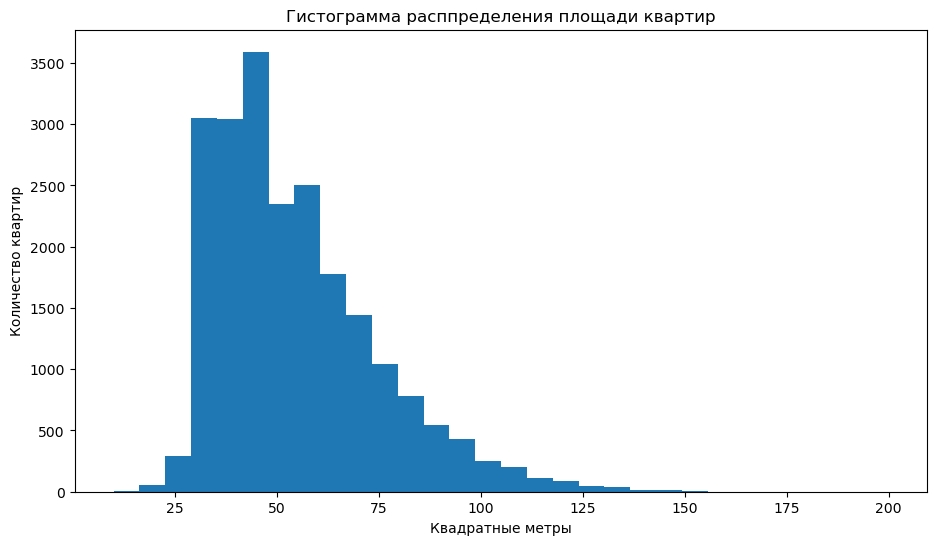

In [112]:
plt.figure(figsize=(11, 6))
plt.hist(df['total_area'], bins=30, range=(10,200))
plt.title('Гистограмма расппределения площади квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

<b>Распределение квартир выглядит правдободобно, можно убрать аномальные значения:

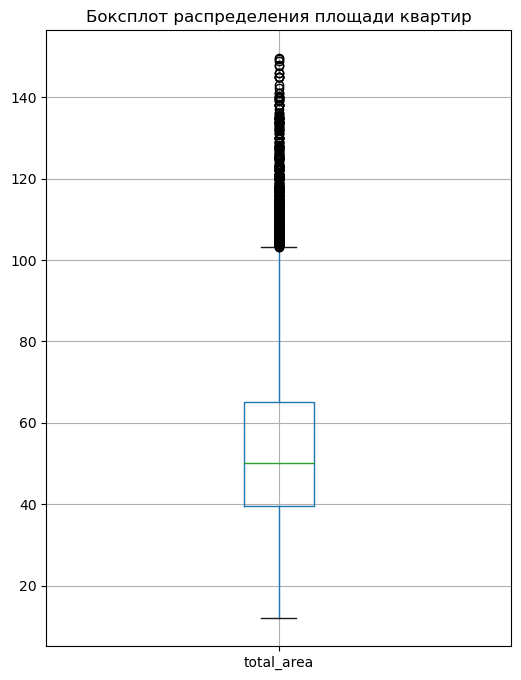

In [122]:
plt.figure(figsize=(6, 8))
df.boxplot(column='total_area')
plt.title('Боксплот распределения площади квартир')
plt.show()

In [45]:
df = df.query('total_area < 150')

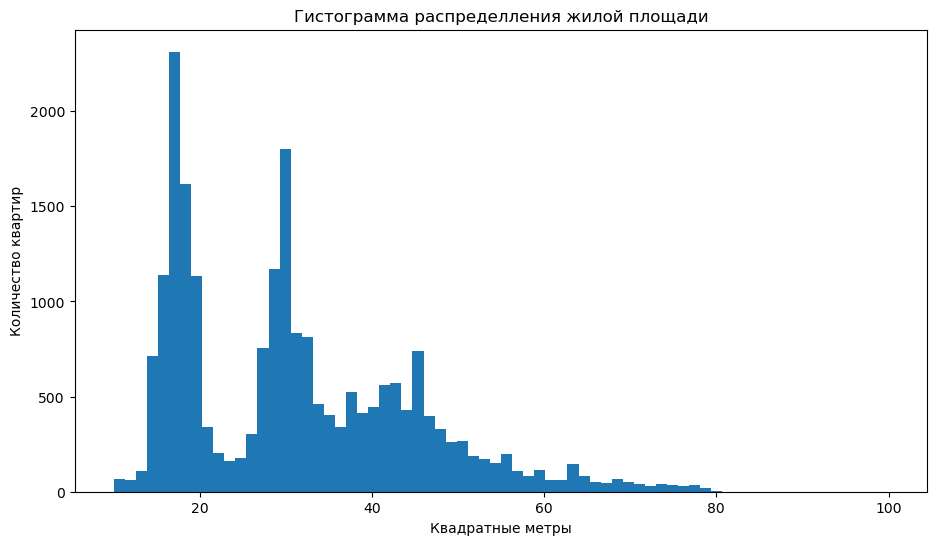

In [121]:
plt.figure(figsize=(11, 6))
plt.hist(df['living_area'], bins=70, range=(10,100))
plt.title('Гистограмма распределления жилой площади')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

<b>Пики на гистограмме показывают жилую площадь у 1,2,3-х комнатных квартир. Здесь тоже можно убрать аномально большие значения:

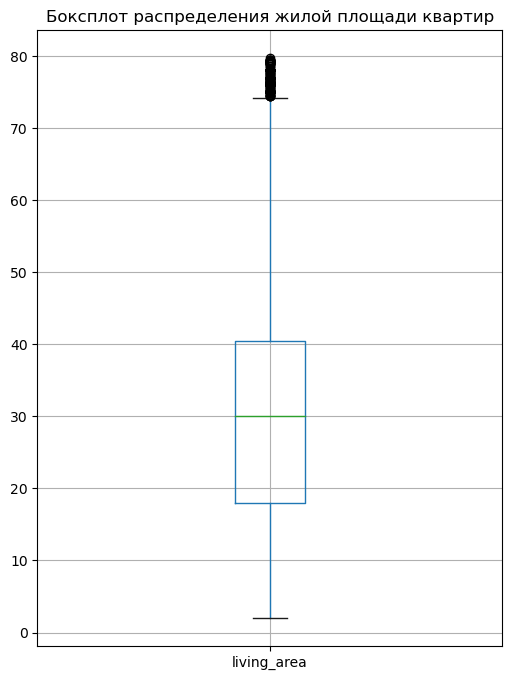

In [124]:
plt.figure(figsize=(6, 8))
df.boxplot(column='living_area')
plt.title('Боксплот распределения жилой площади квартир')
plt.show()

In [48]:
df = df.query('living_area < 80') 

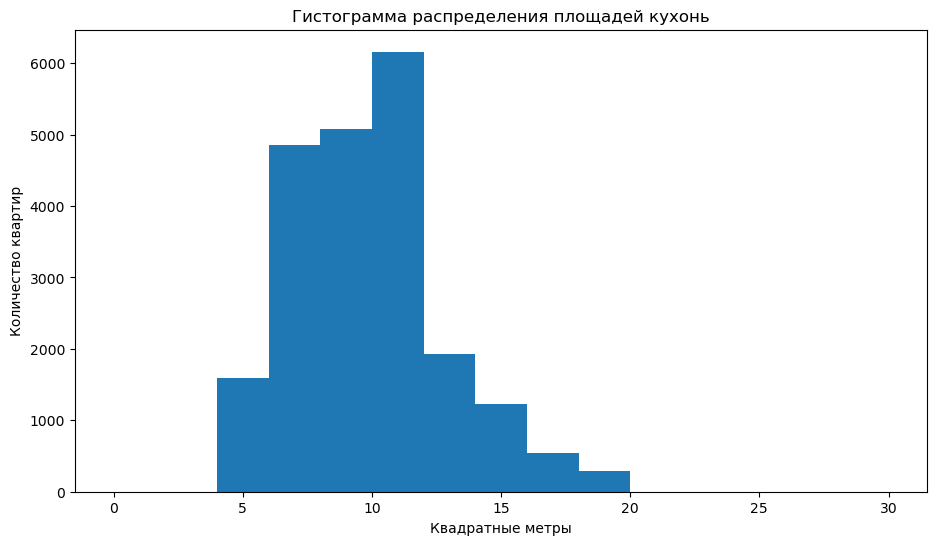

In [125]:
plt.figure(figsize=(11, 6))
plt.hist(df['kitchen_area'], bins=15, range=(0,30))
plt.title('Гистограмма распределения площадей кухонь')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

<b>Видно, что размах площади кухни невысок. Убираем большие значения:

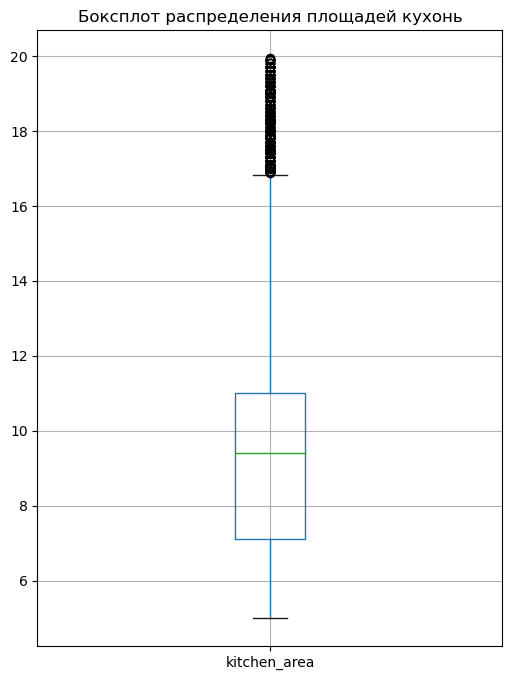

In [126]:
plt.figure(figsize=(6, 8))
df.boxplot(column='kitchen_area')
plt.title('Боксплот распределения площадей кухонь')
plt.show()

In [51]:
df = df.query('kitchen_area < 20') 

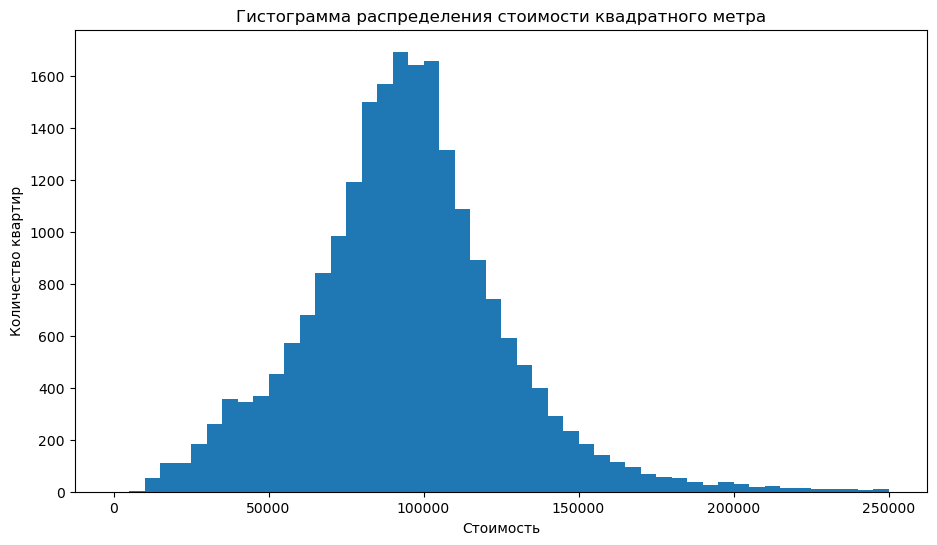

In [149]:
plt.figure(figsize=(11, 6))
plt.hist(df['meter_price'], bins=50, range=(0,250000))
plt.title('Гистограмма распределения стоимости квадратного метра')
plt.xlabel('Стоимость')
plt.ylabel('Количество квартир')
plt.show()

<b>Как видно из графика, цена квартир за метр подчиняется нормальному распределению.

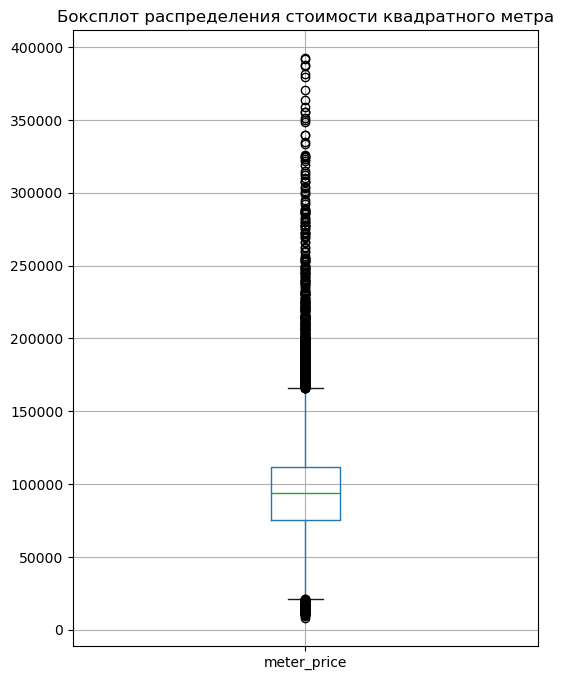

In [128]:
plt.figure(figsize=(6, 8))
df.boxplot(column='meter_price')
plt.title('Боксплот распределения стоимости квадратного метра')
plt.show()

In [54]:
df = df.query('meter_price < 400000') 
#цена на элитное жилье может быть сильно завышенной при тех же
#параметрах, поэтому удаляем не все выбивающиеся значения

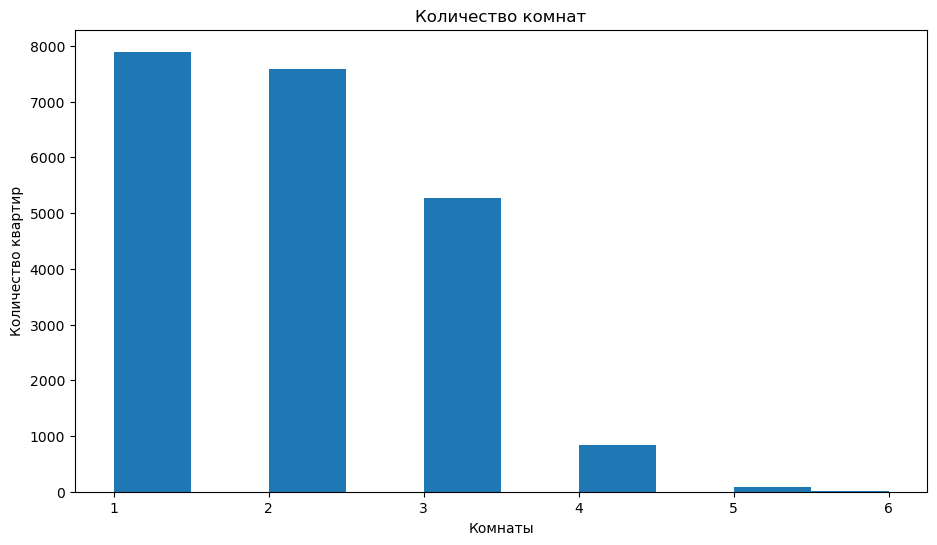

In [129]:
plt.figure(figsize=(11, 6))
df = df.query('rooms > 0')
plt.hist(df['rooms'])
plt.title('Количество комнат')
plt.xlabel('Комнаты')
plt.ylabel('Количество квартир')
plt.show()

<b>Количество однокомнатных и двухкомнатных квартир примерно одинаково, трехкомнатных меньше. Другие варианты гоаздо малочисленнее.</b>

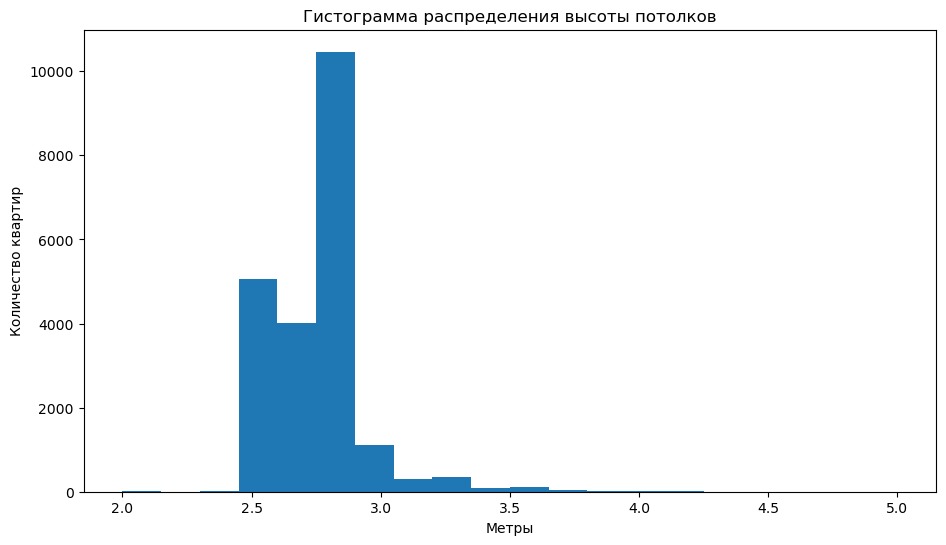

In [131]:
plt.figure(figsize=(11, 6))
plt.hist(df['ceiling_height'], range=(2,5), bins=20)
plt.title('Гистограмма распределения высоты потолков')
plt.xlabel('Метры')
plt.ylabel('Количество квартир')
plt.show()

<b>По общедоступным данным, средняя высота потолка в квартире - 2,7 м. График это подтверждает.</b>

In [57]:
np.round(df['ceiling_height'].median(), 3)

2.771

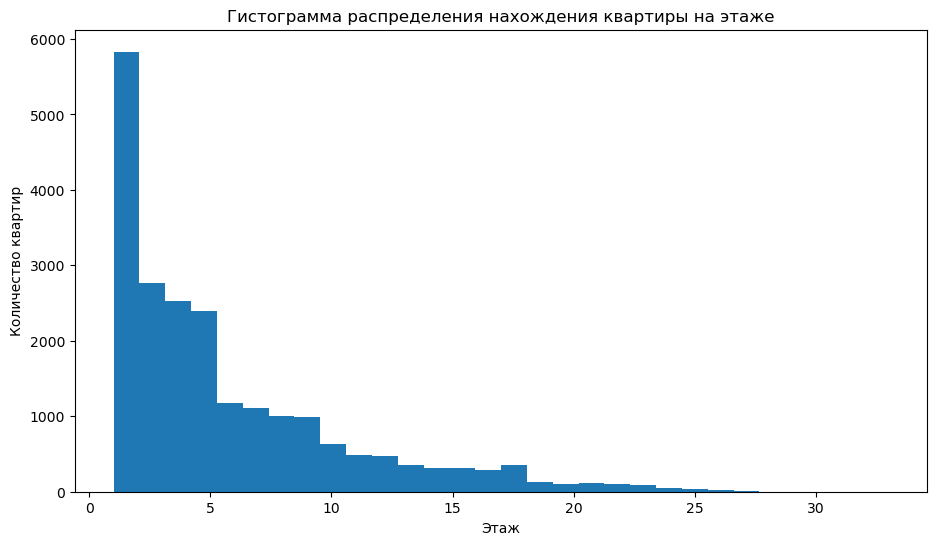

In [133]:
plt.figure(figsize=(11, 6))
plt.hist(df['floor'], bins=30)
plt.title('Гистограмма распределения нахождения квартиры на этаже')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
plt.show()

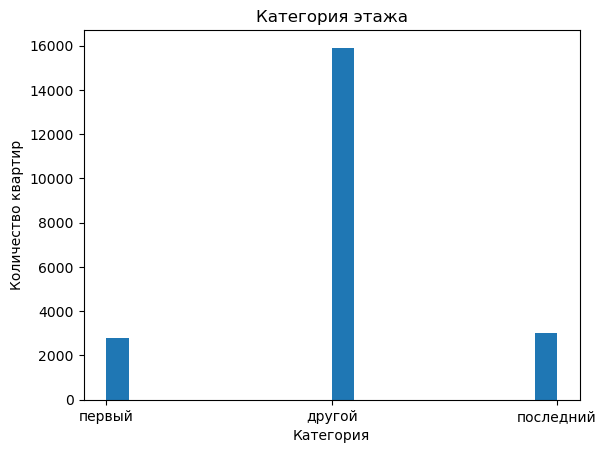

In [134]:
plt.hist(df['floor_category'], bins=20)
plt.title('Категория этажа')
plt.xlabel('Категория')
plt.ylabel('Количество квартир')
plt.show()

<b>Квартиры на первых и последних этажах покупают одинаково.</b>

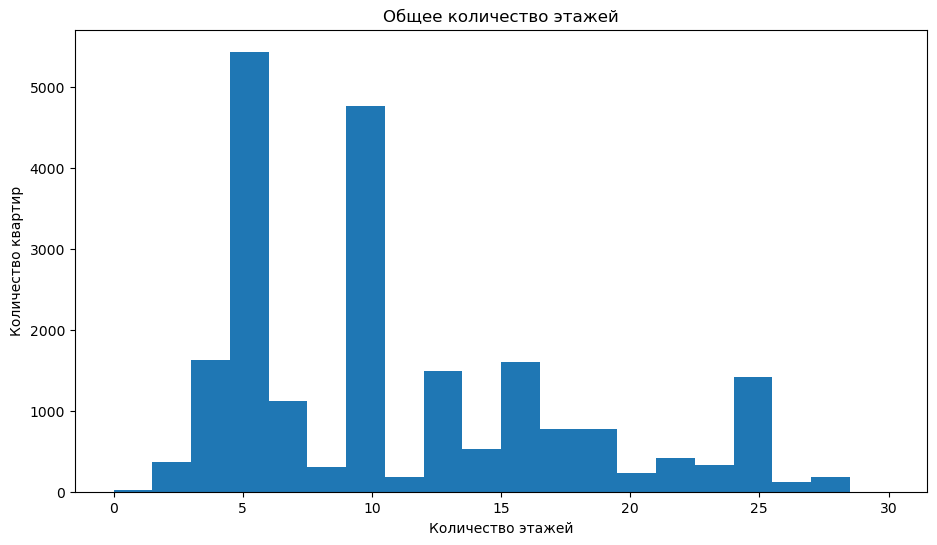

In [135]:
plt.figure(figsize=(11, 6))
plt.hist(df['floors_total'], bins=20, range=(0, 30))
plt.title('Общее количество этажей')
plt.xlabel('Количество этажей')
plt.ylabel('Количество квартир')
plt.show()

<b>Больше всего квартир продаются в пятиэтажках (скорее всего - советские хрущевки). По данным из открытых источников, этажность самого высокого жилого здания составляет 37 этажей. Удалим всё, что меньше:

In [61]:
df = df.query('floors_total < 37 and floors_total > 0') 

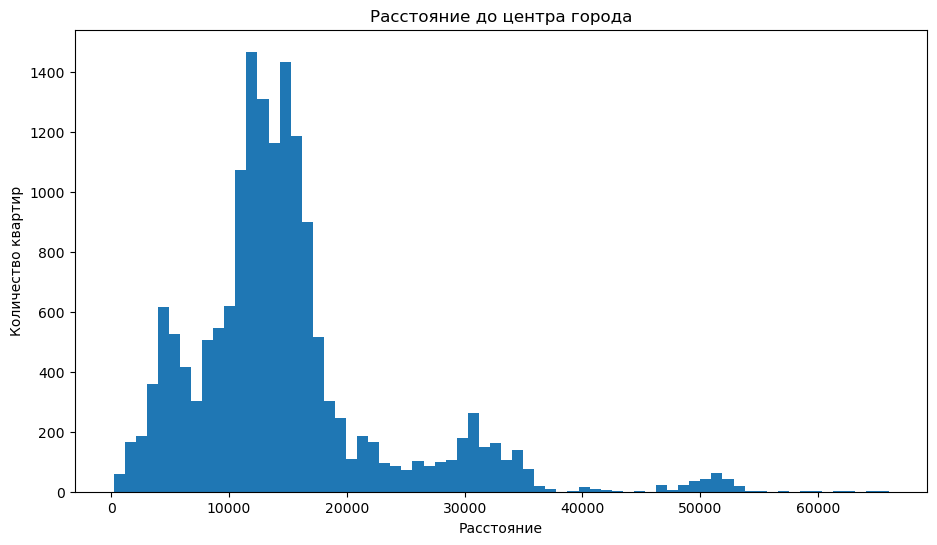

In [136]:
plt.figure(figsize=(11, 6))
plt.hist(df['cityCenters_nearest'], bins=70)
plt.title('Расстояние до центра города')
plt.xlabel('Расстояние')
plt.ylabel('Количество квартир')
plt.show()

<b>Большинство квартир находится на расстоянии примерно от 7 км до 17 км от центра города.

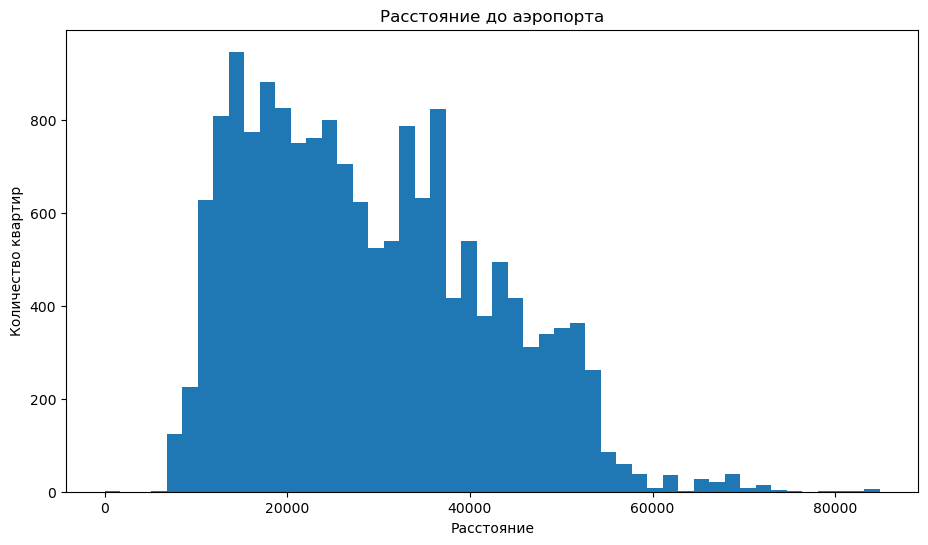

In [137]:
plt.figure(figsize=(11, 6))
plt.hist(df['airports_nearest'], bins=50)
plt.title('Расстояние до аэропорта')
plt.xlabel('Расстояние')
plt.ylabel('Количество квартир')
plt.show()

<b>Видно, что значений возле 0 немного - значит, данные правдоподобны. Дальше 60 км на графике квартир почти нет - скорее всего, в объявлении это значение просто не отражается.

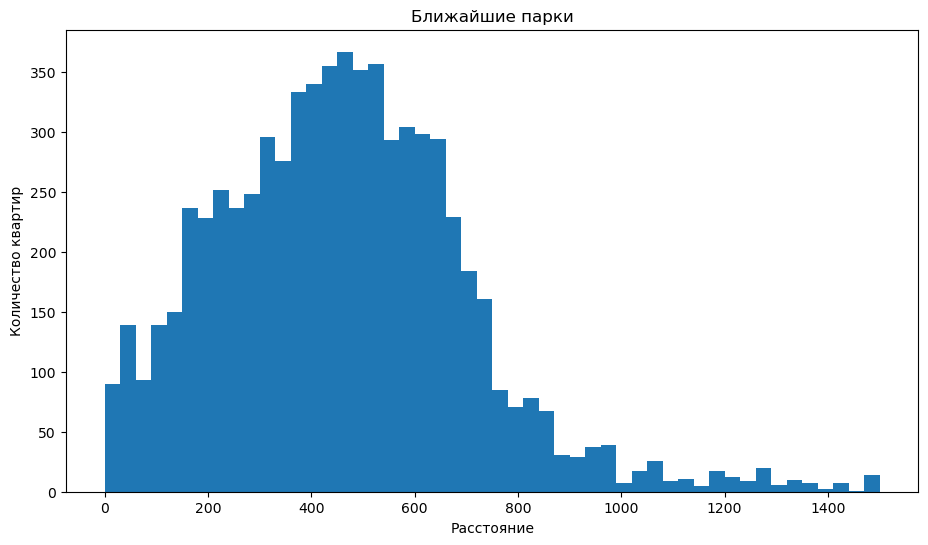

In [138]:
plt.figure(figsize=(11, 6))
plt.hist(df['parks_nearest'], bins=50, range=(0, 1500))
plt.title('Ближайшие парки')
plt.xlabel('Расстояние')
plt.ylabel('Количество квартир')
plt.show()

<b> Здесь видим что-то похоже на нормальное распределение до 900 м, дальше этого значений квартир крайне мало.

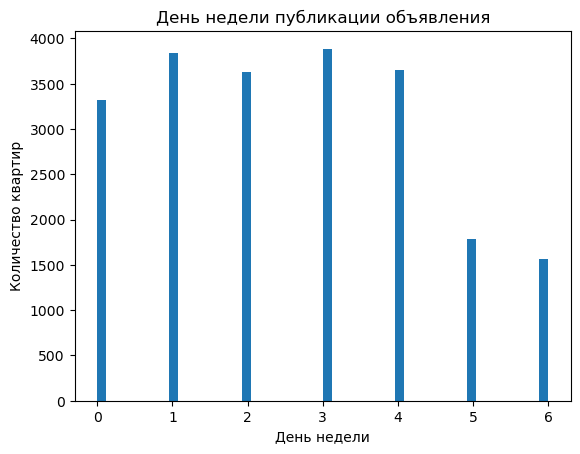

In [65]:
plt.hist(df['weekday'], bins=50)
plt.title('День недели публикации объявления')
plt.xlabel('День недели')
plt.ylabel('Количество квартир')
plt.show()

<b>Меньше всего объявлений выкладывают в субботу и воскресенье - выходные, как-никак.</b>

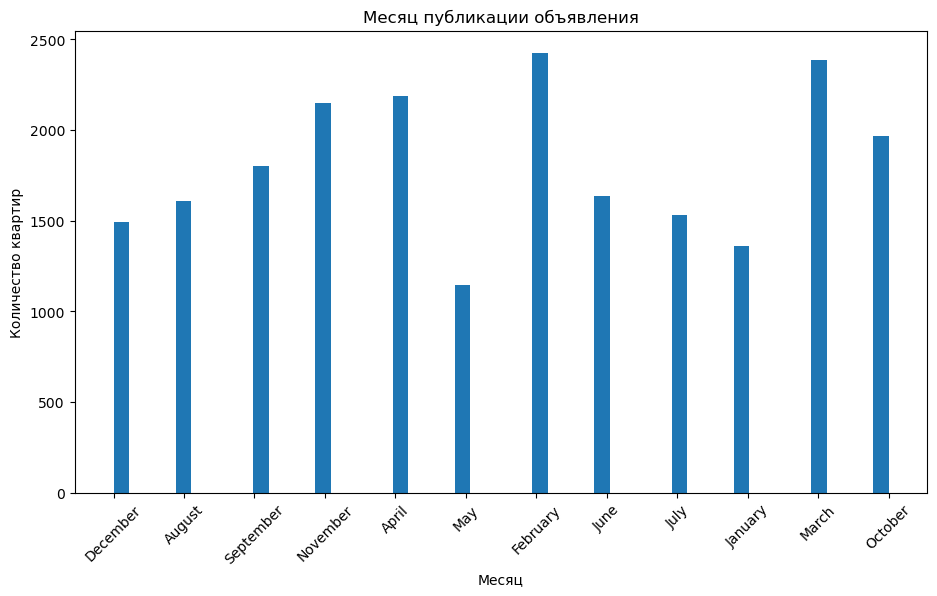

In [140]:
plt.figure(figsize=(11, 6))
plt.hist(df['month'], bins=50)
plt.title('Месяц публикации объявления')
plt.xlabel('Месяц')
plt.ylabel('Количество квартир')
plt.xticks(rotation=45)
plt.show()

<b>Видим, что в мае и январе выкладывают меньше всего объявлений, в феврале и марте - больше всего.</b>

In [67]:
np.round((null_shape[0] - df.shape[0]) / null_shape[0] * 100, 3)

8.515

<b>Таким образом, мы удалили 8.5 % значений, что не критично.</b>

<b>2. Изучим, как быстро продавались квартиры.</b>

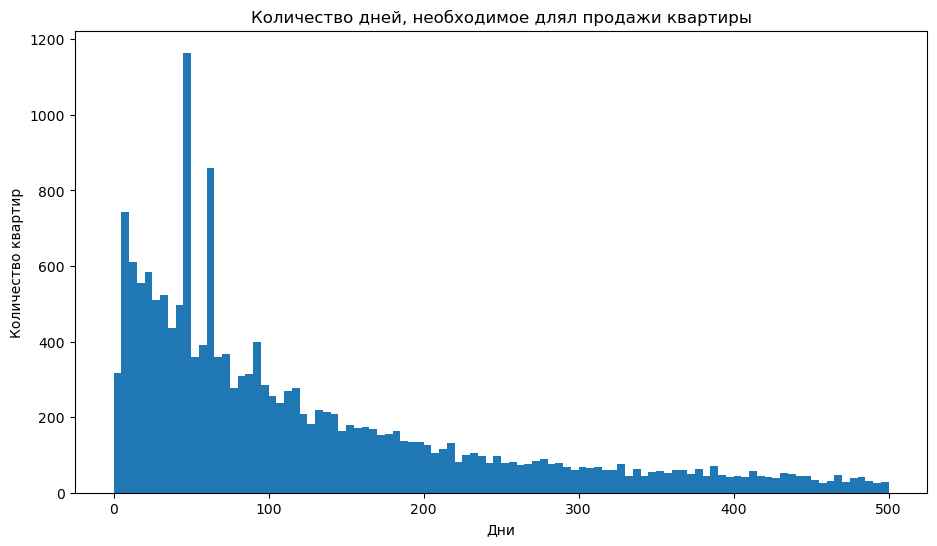

In [142]:
plt.figure(figsize=(11, 6))
plt.hist(df['days_exposition'], bins=100, range=(0,500))
plt.title('Количество дней, необходимое длял продажи квартиры')
plt.xlabel('Дни')
plt.ylabel('Количество квартир')
plt.show()

<b>Видно, что после 250 дней количество проданных квартир стабилизируется. Отсечем большие значения:

In [69]:
good_exposition = df.query('days_exposition < 250')

<b>Рассчитаем среднее и медиану:

In [70]:
good_exposition['days_exposition'].agg(['mean','median'])

mean      82.747534
median    62.000000
Name: days_exposition, dtype: float64

<b>Вывод: в среднем продажа квартир занимает 2-3 месяца. Быстрыми можно считать продажи до 2 месяцев, долгими - дольше 3 месяцев, причем долгие продажи могут быть действительно "долгими". На гистограмме так же видно два пика, нужно уточнить этот момент у сервиса, возможно, через какое-то время объявление снимают или размещают повторно. 

In [71]:
df['days_exposition'].value_counts()

45.0      863
60.0      520
7.0       222
30.0      189
4.0       167
         ... 
693.0       1
1060.0      1
1081.0      1
783.0       1
971.0       1
Name: days_exposition, Length: 1104, dtype: int64

In [148]:
good_exposition = good_exposition.dropna(subset=['days_exposition'])
good_exposition = good_exposition.astype({'days_exposition':'int'})
good_exposition = good_exposition.query('days_exposition != 45 and days_exposition != 60')
good_exposition['days_exposition'].value_counts()

7      222
30     189
4      167
3      147
90     145
      ... 
148     12
242     12
243     10
2        3
1        1
Name: days_exposition, Length: 247, dtype: int64

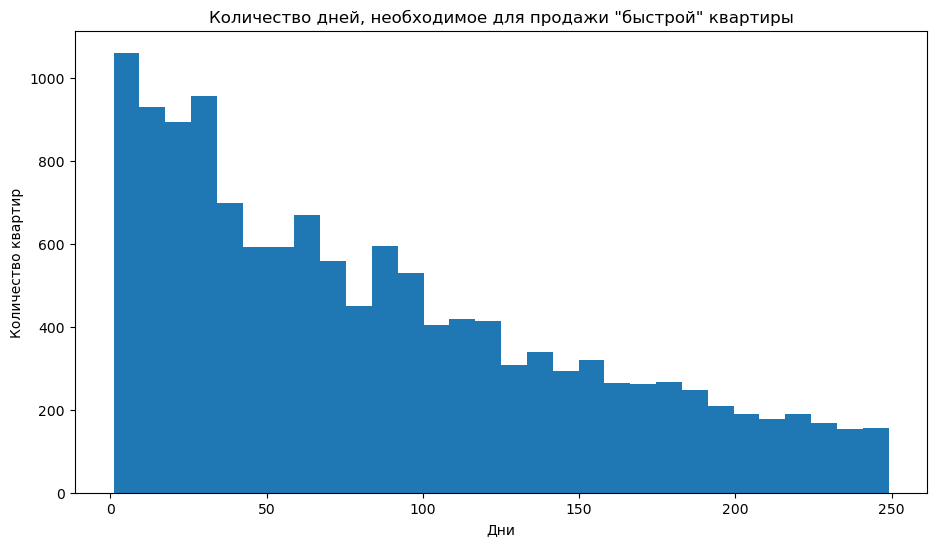

In [147]:
plt.figure(figsize=(11, 6))
plt.hist(good_exposition['days_exposition'], bins=30)
plt.xlabel('Дни')
plt.ylabel('Количество квартир')
plt.title('Количество дней, необходимое для продажи "быстрой" квартиры')
plt.show()

In [77]:
good_exposition['days_exposition'].agg(['mean','median']).round(3)

mean      86.082
median    71.000
Name: days_exposition, dtype: float64

<b>3. Изучим, какие факторы больше всего влияют на стоимость:</b>

                     living_area  total_area     rooms  cityCenters_nearest  \
living_area             1.000000    0.906822  0.900095            -0.158352   
total_area              0.906822    1.000000  0.791289            -0.177752   
rooms                   0.900095    0.791289  1.000000            -0.110336   
cityCenters_nearest    -0.158352   -0.177752 -0.110336             1.000000   
last_price              0.578134    0.717514  0.419847            -0.328643   

                     last_price  
living_area            0.578134  
total_area             0.717514  
rooms                  0.419847  
cityCenters_nearest   -0.328643  
last_price             1.000000  


<Figure size 1100x1100 with 0 Axes>

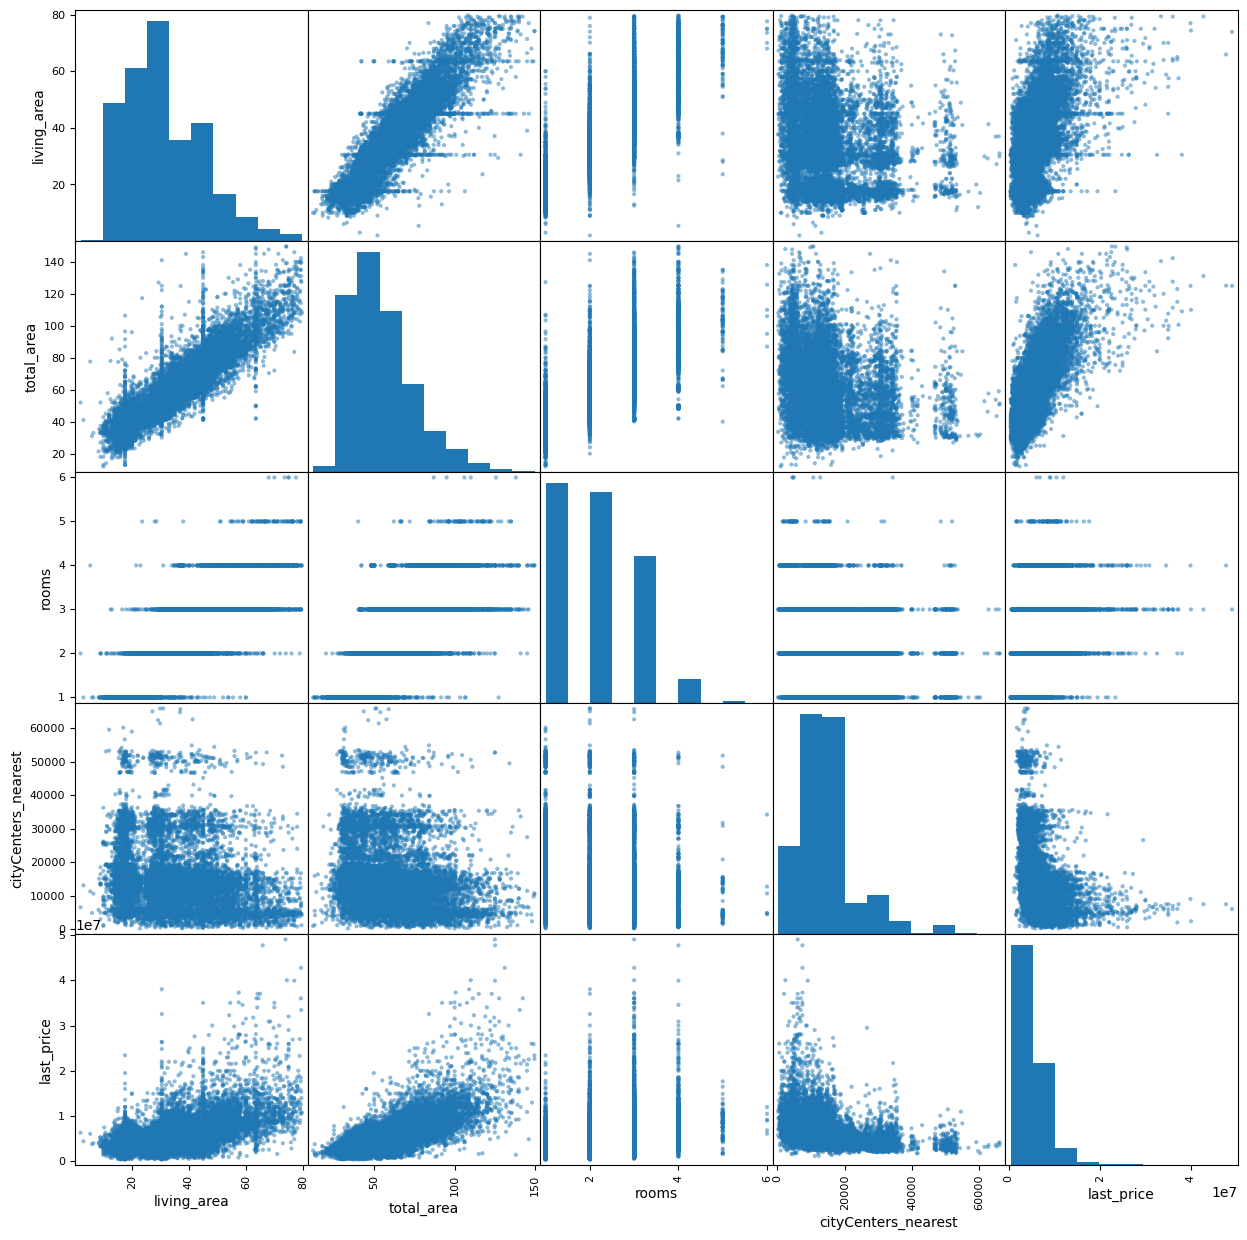

In [144]:
columns_one = ['living_area','total_area', 'rooms',
               'floor_category','cityCenters_nearest','last_price']
print(df[columns_one].corr())
plt.figure(figsize=(11, 11))
pd.plotting.scatter_matrix(df[columns_one],figsize=(15,15))
plt.show()

<b>Цена относительно сильно зависит от общей площади, меньше от жилой площади. От остальных параметров цена зависит слабо (но не сказать, чтобы не зависит полностью).

             weekday      year  last_price
weekday     1.000000 -0.001629   -0.012771
year       -0.001629  1.000000   -0.014659
last_price -0.012771 -0.014659    1.000000


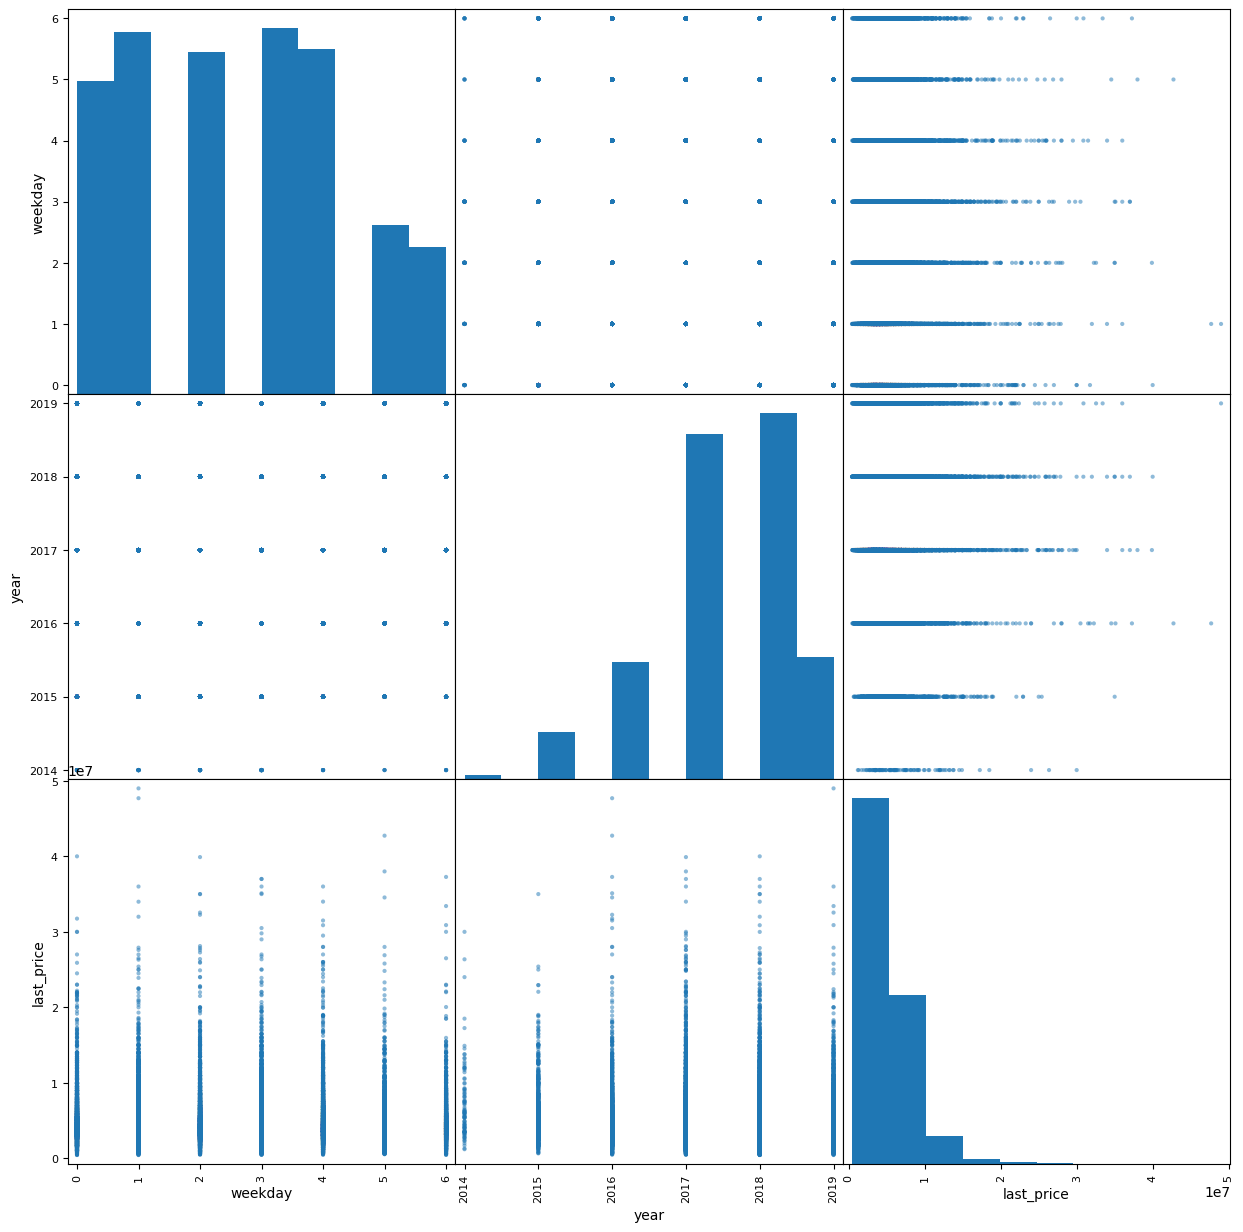

In [79]:
columns_two = ['weekday','month','year','last_price']
print(df[columns_two].corr())
pd.plotting.scatter_matrix(df[columns_two],figsize=(15,15))
plt.show()

<b>Очевидно, дата объявления не влияет на конечную цену</b>

<b>4. Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. </b>

In [80]:
top_locality = df['locality_name'].value_counts().head(10).index

locality_mean_price = (df.query('locality_name in @top_locality')
                         .pivot_table(index = 'locality_name',
                                      values = 'meter_price',
                                      aggfunc = ['count','mean']))

locality_mean_price.columns = ['count', 'meter_price']

display(locality_mean_price.sort_values(by='meter_price', ascending=False)
                           .style.format({'meter_price': '{:.0f}'}))

,count,meter_price
locality_name,,
Санкт-Петербург,14050,109266
Пушкин,337,101348
Кудрово,428,95409
посёлок Парголово,319,90410
Мурино,550,85614
посёлок Шушары,428,78258
Колпино,332,75388
Гатчина,302,68610
Всеволожск,381,66959


<b>Самые дорогие метры жилья в Санкт-Петербурге, за пределами - в Пушкине, а самый дешевый метр из десятки - в Выборге.</b>

<b>5. Ранее мы посчитали расстояние до центра в километрах. Рассмотрим связь расстояния до центра и цену за квадратный метр. </b>

In [81]:
km_mean_price = (df.query('locality_name == "Санкт-Петербург"')
                   .pivot_table(index = 'citycenters_nearest_km',
                                values = 'meter_price',
                                aggfunc = ['count','mean']))
km_mean_price.columns = ['count', 'meter_price']
km_mean_price = km_mean_price.drop('count', axis=1).reset_index()
km_mean_price.columns = ['km', 'meter_price']
display(km_mean_price.head(10).style.format({'meter_price': '{:.0f}',
                                             'km':'{:.0f}'}))

,km,meter_price
0,0,122958
1,1,135796
2,2,131055
3,3,117164
4,4,124723
5,5,131302
6,6,132907
7,7,133145
8,8,120356
9,9,111535


<Figure size 1100x600 with 0 Axes>

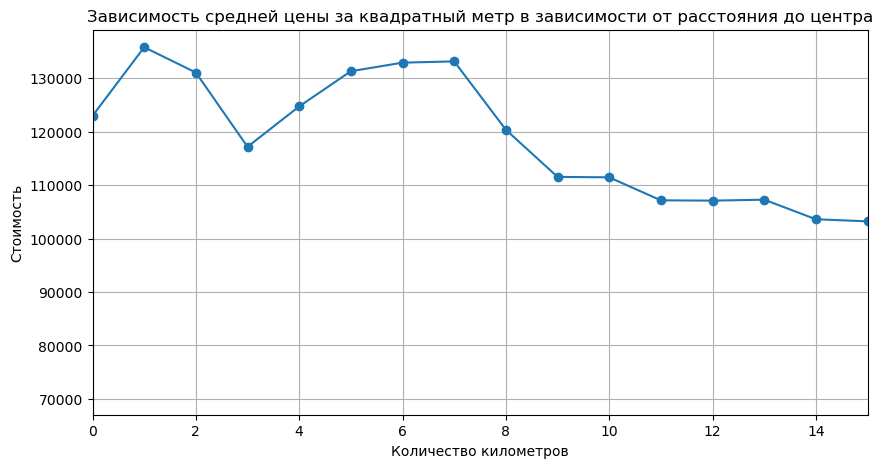

In [158]:
plt.figure(figsize=(11, 6))
km_mean_price.plot(x='km', y='meter_price', grid=True, style='o-',
                   xlim=(0,15), figsize=(10, 5), legend=False)
plt.title('Зависимость средней цены за квадратный метр в зависимости от расстояния до центра')
plt.xlabel('Количество километров')
plt.ylabel('Стоимость')
plt.show()

<b>Можно заметить снижение цены на расстроении 3 км, однако, после 9 км цена становится стабильной, из чего сделаем вывод, что центр города можно обозначить радиусом 8-9 км.</b>

### Общий вывод

<b>Сперва, мы выгрузили датасет и заполнили пропуски в данных (коих было довольно большое количество), где это возможно, устранили дубликаты и поменяли формат некоторых столбцов.

После обработки мы добавили новые критерии для объявлений и поместили их в таблицу. 

В ходе исследовательского анализа данных мы удалили некоторые аномальные значения и изучили основные параметры жилья с помощью графиков, выявили закономерности. Далее, было рассмотрено, на сколько быстро продаются квартиры, какие факторы больше всего влияют на стоимость (это общая площадь и жилая). Было выполнено два задания - была подсчитана цена квартиры в квадратных метра в 10 населённых пунктах с наибольшим числом объявлений и цены квартир в зависимости  от расстояния от центра в километрах.

Главное наблюдение исследования - большинство квартир на рынке находятся в Санкт-Петербурге, являются одно- или двухкомнатными, со стандартными характеристиками (высота потолков, этаж и т.п.). Обработанные данные и выявленные закономерности могут помочь сервису для составления более полных данных и построения хорошей модели для подбора жилья для пользователя (например, предложить бюджетный вариант, но с параметрами, необходимыми пользователю.